# Life 101

In this notebook, we create a simple analogy between Wikispeedia game and "Life". We found out that some advices given in the game are also applicable in real life and we can learn from them! 

# Data Preparation

In [30]:
from numpy.lib.utils import source
import matplotlib.pyplot as plt
import src.utils as utils
from scipy import stats
# import src.LLM as LLM

# automatically reload the module in case of changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
finished_paths = utils.load_dataframe("./data/wikispeedia_paths-and-graph/paths_finished.tsv", skip_rows=16, columns=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

unfinished_paths = utils.load_dataframe("./data/wikispeedia_paths-and-graph/paths_unfinished.tsv", skip_rows=16, columns=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])

categories = utils.load_dataframe("./data/wikispeedia_paths-and-graph/categories.tsv", skip_rows=12, columns=["page", "category"])

links_df = utils.load_dataframe("./data/wikispeedia_paths-and-graph/links.tsv", skip_rows=12, columns=["source", "target"])

In [32]:
categories_dict = utils.manage_categories(categories.copy())
finished_paths_df = utils.manage_paths(finished_paths.copy(), categories_dict.copy())
unfinished_paths_df = utils.manage_paths(unfinished_paths.copy(), categories_dict.copy())
links_dict = utils.manage_links(links_df.copy())
graph = utils.create_graph(links_df.copy())
finished_paths_df.to_csv("./data/clean_data/clean_finished_paths.csv")
unfinished_paths_df.to_csv("./data/clean_data/clean_unfinished_paths.csv")


c:\Users\hasse\Documents\MA1\ADA\project\ada-2024-project-tadaa\src\utils.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  paths_df['nb_back_clicks'] = paths_df['path'].apply(lambda x: x.count('<'))


# Don't trust LLMs blindly! (Not you Copilot, you know I love you)

We will compare people performance to LLM performance by condidering the most taken paths by people and launching them on a 4bit quantized version of Qwen-3b. A fairly small LLM that could run on our machines/Colab in a reasonable time. We run the same task from source to target 100 times using the LLM. This allows us to have statistically relevant paths especially that the LLM is sometimes lost and not able to finish the paths everytime



## Prompting strategy
In order to get the model to work, we did prompt engineering trying multiple instructionns for the model. A detailed explanation is available in the read me. The overall idea of the prompt is that we give the model only the target and the list of possible links at a certain step and we ask it about the best choice in order to get closer to the target. If the answer is not in the list, we keep the context of the conversation and we tell the model that it gave us an article not in the list and we ask it to correct itself. If it does, then we continue otherwise, the path is considered aborted.
If we have an answer we restart with a completely new context using a similar prompt.

## Comparison strategy
As we get multiple sample of answers (100 in our case) from the LLM for each source-target pair, we get an estimate of the distribution of lengths of the paths given by the LLM. Similarly, we have multiple samples of player paths, so we can not only compare the means of the path lengths but also do a t-test similarity test to know if the distributions are similar or not.

In [77]:
top_paths = finished_paths_df.groupby(["source", "target"]).count().sort_values(by="hashedIpAddress", ascending=False).reset_index()
top_paths = top_paths.rename(columns={"hashedIpAddress": "count"}).head(10)
sources = top_paths['source'].tolist()
targets = top_paths['target'].tolist()
# paths = LLM.llm_paths(sources, targets, links_dict)
llm_paths = utils.read_llm_paths("./data/llm_paths.json")


In [84]:

def plot_llms_vs_players():
    llm_means = []
    llm_std_errors = []
    player_means = []
    player_std_errors = []

    for source, target in zip(sources, targets):
        player_paths = finished_paths_df[(finished_paths_df["source"] == source) & (finished_paths_df["target"] == target)]
        player_mean_length = player_paths["path_length"].mean()
        player_std_error = player_paths["path_length"].sem()
        player_std_errors.append(player_std_error)
        player_means.append(player_mean_length)
        
        llm_source_target = llm_paths[source+"_"+target]
        llm_mean_length = 0
        for path in llm_source_target:
            llm_mean_length += len(path)
        llm_mean_length /= len(llm_source_target)
        llm_std_error = 0
        for path in llm_source_target:
            llm_std_error += (len(path) - llm_mean_length)**2
        llm_std_error /= len(llm_source_target)
        llm_std_error = llm_std_error**0.5
        llm_means.append(llm_mean_length)
        llm_std_errors.append(llm_std_error)
    fig, ax = plt.subplots()
    ax.errorbar(range(10), player_means, yerr=player_std_errors, fmt="o", label="Player Paths")
    ax.errorbar(range(10), llm_means, yerr=llm_std_errors, fmt="o", label="LLM Paths")
    ax.set_xticks(range(10))
    ax.set_xticklabels([f"{source} -> {target}" for source, target in zip(sources, targets)], rotation=90)  
    ax.set_ylabel("Path Length")
    ax.set_xlabel("Source -> Target")
    plt.title("Player Paths vs LLM mean path length per source-target pair")
    ax.legend()
    plt.show()


def tstats_pvalues():
    t_stats = []
    p_values = []
    t_critical = []
    for source, target in zip(sources, targets):
        player_paths = finished_paths_df[(finished_paths_df["source"] == source) & (finished_paths_df["target"] == target)]
        llm_source_target = llm_paths[source+"_"+target]
        t_stat, p_value = stats.ttest_ind(player_paths["path_length"], [len(path) for path in llm_source_target])
        t_stats.append(abs(t_stat))
        p_values.append(p_value)  
        t_critical.append(stats.t.ppf(1-0.05/2, len(player_paths["path_length"]) + len(llm_source_target) - 2))
    return t_stats, p_values, t_critical

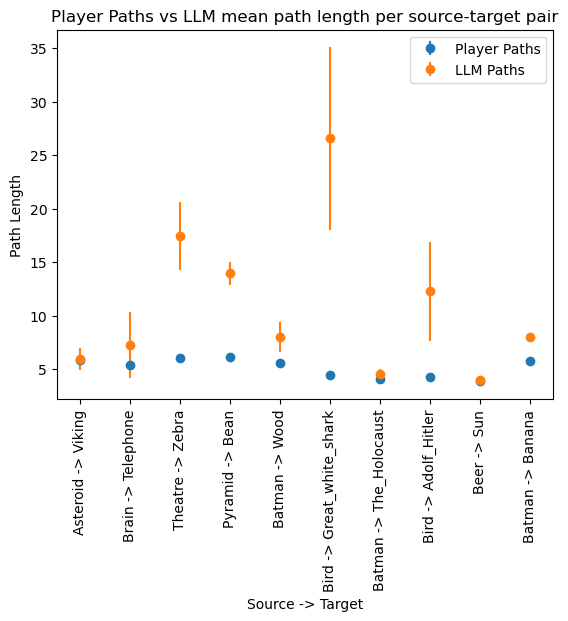

c:\Users\hasse\anaconda3\envs\ada\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


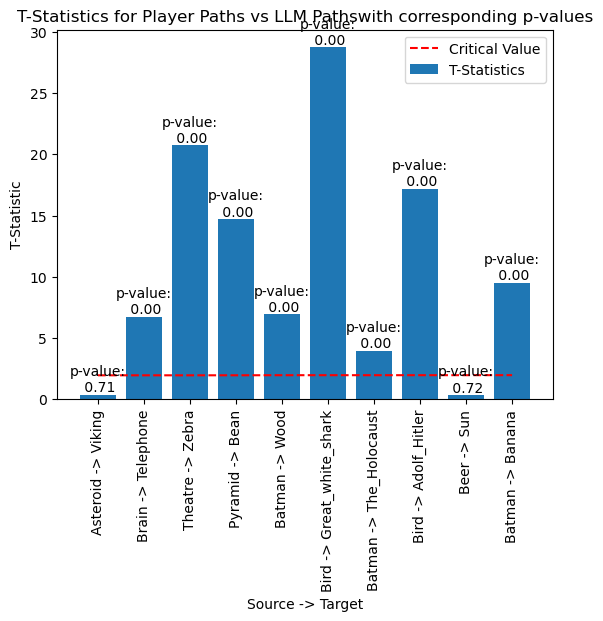

In [87]:
plot_llms_vs_players()       
t_stats, p_values, t_critical = tstats_pvalues()
fig, ax = plt.subplots()
ax.bar(range(10), t_stats, label='T-Statistics')
ax.plot(range(10), t_critical, label='Critical Value', linestyle='--', color='red')
# write p-values on top of the bars
for i, p_value in enumerate(p_values):
    ax.text(i, t_stats[i], f"p-value:\n {p_value:.2f}", ha='center', va='bottom')
    
ax.set_xticks(range(10))
ax.set_xticklabels([f"{source} -> {target}" for source, target in zip(sources, targets)], rotation=90)
ax.set_ylabel("T-Statistic")
ax.set_xlabel("Source -> Target")
plt.title("T-Statistics for Player Paths vs LLM Pathswith corresponding p-values")
ax.legend()
plt.show()





The first plot shows that the LLM's performance is worse in about all the source-target pairs. However, we are not confident that it's better in all of them. (for example, the players mean falls into the standard error of the LLM mean for the Brain-Telephone paths). This is why we also calculate the t-statistics and the corresponding p-values. We can see that the for all the source-target pairs other than Asteroid->Viking and Batman->Banana, the t-test is larger than the critical values and with corresponding p-values for which we cannot reject the hypothesis that the distributions are not similar. For the two excetions Asteroid->Viking and Batman->Banana, even though the t-test is lower than the critical value, the corresponfing p-values (0.71 and 0.72) are very high such that we can reject the hypothesis that the distributions are similar.